### Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from scipy.stats import linregress
import json
import math
from collections import Counter
import numpy as np
from scipy.optimize import curve_fit
import statistics as stat
import matplotlib.colors as mcolors
from scipy.stats import mannwhitneyu
import matplotlib.lines as mlines
from sklearn.linear_model import LinearRegression
from scipy import stats

### Functions

In [2]:
#function to fit polynomial model
def fit_polynomial(data, x_col, y_col, order=2, num_bootstraps=1000, ci_level=0.95):
    x = np.array(list(data[x_col]))
    y = np.array(list(data[y_col]))
    
    # Fit a polynomial regression
    coefficients = np.polyfit(x, y, order)
    model = np.poly1d(coefficients)
    
    # Generate the fitted curve using the model
    y_fit = model(x)
    
    # Calculate the residuals
    residuals = y - y_fit
    
    # Calculate a simple confidence interval (adjust as needed)
    ci = 2 * np.std(y_fit) / np.sqrt(len(y_fit))
    
    output = {
        'y_pred': y_fit,
        'residuals': residuals,
        'x_values': x,
        'ci' : ci
    }
    
    print(f"\nPolynomial Regression (Order {order}) Model Fit Summary:\n")
    print(f"Model Equation:\n{model}")
    
    sum_squared_residuals = np.sum(residuals**2)
    print(f"Sum of squared residuals: {sum_squared_residuals}")
    
    return output

# Functions to fit linear model
def linear_model(x, m, c):
    return m * x + c

# Function to fit a linear model
def fit_linear_model(data, x_col, y_col):
    x = np.array(list(data[x_col]))
    y = np.array(list(data[y_col]))

    # Fit the linear model
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Generate the fitted line using the parameters
    y_fit = linear_model(x, slope, intercept)

    # Calculate the residuals
    residuals = y - y_fit
    
    # Sort the x and y_fit values for plotting
    x_obs, y_pred = zip(*sorted(zip(x, y_fit)))
    
    #calculate confidence interval
    ci = 2 * np.std(y_pred) / np.sqrt(len(y_pred))
    
    output = {'y_pred': y_pred, 'residuals': residuals, 'x_values': x_obs, 'ci': ci}

    print("\nLinear Model Fit Summary:\n")
    print(f"Fitted Parameters:\n"
          f"Slope (m) = {slope}\n"
          f"Intercept (c) = {intercept}")
    
    sum_squared_residuals = np.sum(residuals**2)
    print(f"Sum of squared residuals: {sum_squared_residuals}")

    return output

#A function to calculate standardized effect score
def calculate_standardized_effect(observed, null):
    #calculate mean of the null
    null_mean = sum(null) / len(null)
    #calculate standard deviation of null
    null_stdev = stat.stdev(null)
    #calculate ses
    obs_minus_null_mean = observed - null_mean
    ses = obs_minus_null_mean / null_stdev
    
    return ses

#function to calculate the probability that the observed effect is greater than the null
def calculate_prob_obs_greater_than_null(observed, null):
    observed_greater_than_null = 0
    for value in null:
        if observed > value:
             observed_greater_than_null += 1
    
    prob_observed_greater_than_null = observed_greater_than_null / len(null)
    return 1 - prob_observed_greater_than_null

#function to calculate 95% CI
def calculate_95_ci(data):
    mean = sum(data) / len(data)
    ci = stats.norm.interval(0.95, loc=mean, scale=stats.sem(data))
    return ci

### PSI-BLAST 5 (E-value cutoff = e-10, %identity cutoff = 30%, query coverage cutoff = 1)

To generate this data, I first used PSI-BLAST with 5 iterations to align the Danaus plexippus protein coding protein sequences to themselves:

    psiblast_dplex_vs_dplex.sh
    
I then defined gene families by using a cutoff e-value of >= 1e-10, a percent identity of >= 30, and a query coverage of 1. I also used a secondary set of less stringent cutoffs (e-value >= 1e-5, percent identity >= 20, and a query coverage of 0.7) to see if including more distantly related members in groups would impact my overall inference.

    get_homologous_groups.py
    
    
After defining gene families, I then partitioned the Danaus plexippus protein sequences into individual fasta files. I then made an alignment for each gene family using MUSCLE, and created maximum likelihood phylogenies using IQTREE (with 1000 bootstraps).

    make_gene_cluster_trees_psiblast_5.py
    
For each gene family, I heirarchically (Ward) clustered genes based on their standardized expression values to generate a dissimilarity tree. Standardization was performed by mean centering (subtracting the mean from each value) and scaling (dividing by the standard deviation). This was done because clustering algorithms will often cluster genes that show dissimilar trends in expression across time, but have more comprable expression magnitudes. After constructing a tree of the expression profiles for each gene family, I calcualted the diversity of each expression profile by summing the branch lengths. I also normalized these values by the number of branches and the numebr of leaves (I'll see if that was necessary). 

For global:

    null_gene_family_diversity_model_global.R
    
*Note: All scripts can be found in the analysis/scripts directory

#### Visualization of homologous group sizes

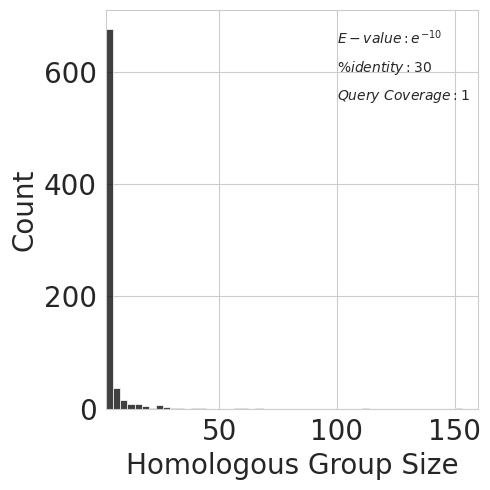

In [74]:
#read homologous groupings
with open('/home/gabe/Desktop/mtstp/data/intermediate_data/gene_cluster_diversity_analysis/psiblast_id-30_e-neg-10_cov-1_sequence_clusters.json') as infile:
    data = json.load(infile)
    
#make list of homologous group sizes
group_sizes = []
for group in data:
    group_sizes.append(len(data[group]))
    
#plot histogram
sns.set_style('whitegrid')
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
sns.histplot(group_sizes, bins=50, kde=False, ax=ax1, color='black')
ax1.set_xlabel('Homologous Group Size', fontsize=20)
ax1.set_ylabel('Count', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_xlim([2, 160])
ax1.text(100, 650, r"$E-value: e^{-10}$", fontsize=10)
ax1.text(100, 600, r"$\%identity: 30$", fontsize=10)
ax1.text(100, 550, r"$Query\ Coverage: 1$", fontsize=10)
plt.tight_layout()
plt.savefig('/home/gabe/Desktop/mtstp/figures/supplement/homologous_group_sizes_histogram_close.pdf')

In [19]:
#show counts of the numbers of groups that will be used in groups size-specific analysis
element_count = Counter(group_sizes)
available_groups = 0
# Print the counts
for element, count in element_count.items():
    if count >= 5 and element > 3:
        print(f"Group Size {element} occurs {count} times")
        available_groups += count
print(f"{available_groups} total groups")

Group Size 4 occurs 44 times
Group Size 13 occurs 5 times
Group Size 11 occurs 6 times
Group Size 5 occurs 26 times
Group Size 6 occurs 15 times
Group Size 7 occurs 11 times
Group Size 8 occurs 10 times
Group Size 9 occurs 5 times
122 total groups


#### Global Correlations

In [3]:
#laod data
data = pd.read_csv("/home/gabe/Desktop/mtstp/data/intermediate_data/gene_cluster_diversity_analysis/gene_family_diversity_vs_expression_diversity_global_data.csv")
#drop rows with NA (indicated a Tree could not be computed for said gene cluster)
data = data.dropna()

In [4]:
data

,cluster,expression.pattern.diversity,centered.expression.pattern.diversity,standardized.expression.pattern.diversity,p.random,mean.tau,upper_tau_ci,lower_tau_ci,gene.cluster.phylogenetic.diversity,n.genes
0,group_0,452.705709,416.985774,20.855320,1.0,0.740595,0.798331,0.682859,21.679998,29.0
2,group_2,361.362393,188.846254,13.324558,1.0,0.633131,0.722461,0.543801,13.610648,24.0
3,group_3,2225.999123,2011.847927,33.485896,1.0,0.719054,0.772811,0.665297,34.506333,61.0
4,group_4,224.322473,185.722104,14.293780,1.0,0.737838,0.802583,0.673094,12.000454,17.0
7,group_7,606.215125,396.011512,4.396072,1.0,0.573473,0.722583,0.424363,1.798719,4.0
...,...,...,...,...,...,...,...,...,...,...
686,group_835,83.223365,68.594040,6.241678,1.0,0.574834,0.884801,0.264866,3.377283,5.0
706,group_857,959.284566,794.184049,1.325648,1.0,0.825884,0.924492,0.727277,1.432116,4.0
732,group_886,114.020761,101.582159,4.235227,1.0,0.755828,1.012006,0.499651,0.967183,4.0
744,group_898,6432.789343,4805.515333,6.587650,1.0,0.738657,0.891901,0.585413,2.769767,6.0


##### Phylogenetic diversity vs group size

Text(0.5, 0, 'Group Size')

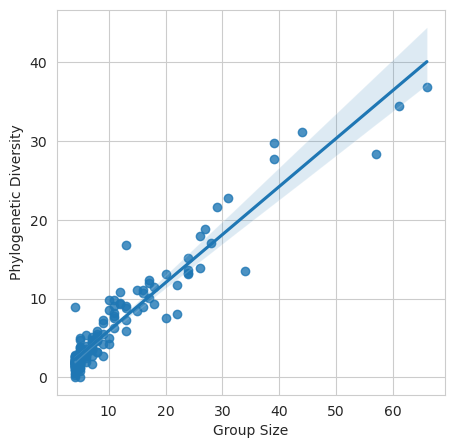

In [4]:
sns.set_style("whitegrid")
sns.set_palette('tab10')
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))

sns.regplot(data=data, y="gene.cluster.phylogenetic.diversity", x="n.genes", ax=ax1, order=1)

ax1.set_ylabel("Phylogenetic Diversity")
ax1.set_xlabel("Group Size")

##### Expression Pattern Diversity vs Group Phylogenetic Diversity and Size

Text(0.5, 0, 'Homologous Group Size')

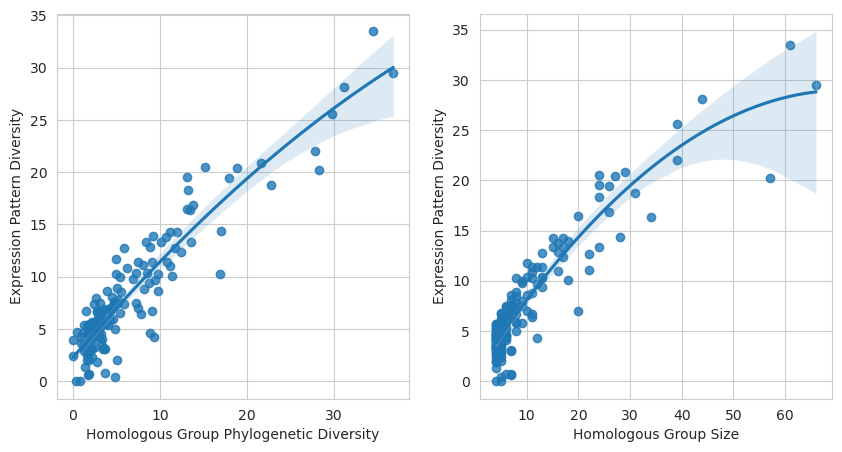

In [43]:
sns.set_style("whitegrid")
sns.set_palette('tab10')
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(10, 5))

sns.regplot(data=data, y="standardized.expression.pattern.diversity", x="gene.cluster.phylogenetic.diversity", ax=ax1, order=2)
sns.regplot(data=data, y="standardized.expression.pattern.diversity", x="n.genes", ax=ax2, order=2)

ax1.set_ylabel("Expression Pattern Diversity")
ax1.set_xlabel("Homologous Group Phylogenetic Diversity")

ax2.set_ylabel("Expression Pattern Diversity")
ax2.set_xlabel("Homologous Group Size")

##### Second order polynomial model fit for expression pattern diversity vs Phylogenetic diversity


Polynomial Regression (Order 2) Model Fit Summary:

Model Equation:
           2
-0.006066 x + 0.9771 x + 2.258
Sum of squared residuals: 750.6054758959806

Linear Model Fit Summary:

Fitted Parameters:
Slope (m) = 0.8056478881334027
Intercept (c) = 2.8104468217616994
Sum of squared residuals: 780.5546399739799


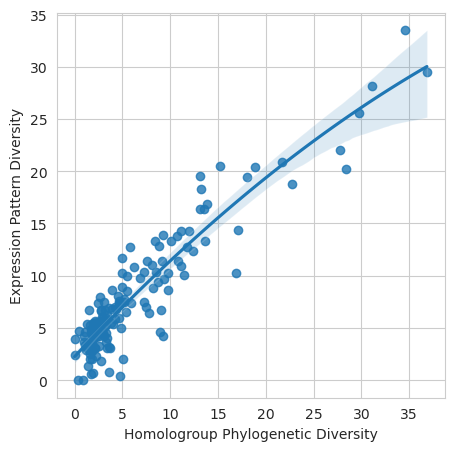

In [44]:
sns.set_style("whitegrid")
sns.set_palette('tab10')
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))

sns.regplot(data=data, y="standardized.expression.pattern.diversity", x="gene.cluster.phylogenetic.diversity", ax=ax1, order=2)

ax1.set_ylabel("Expression Pattern Diversity")
ax1.set_xlabel("Homologroup Phylogenetic Diversity")

#fit models
global_polynomial_model = fit_polynomial(data, y_col="standardized.expression.pattern.diversity", 
                                                     x_col="gene.cluster.phylogenetic.diversity")
global_linear_fit_model = fit_linear_model(data, y_col="standardized.expression.pattern.diversity", 
                                                     x_col="gene.cluster.phylogenetic.diversity")

##### Linear models by homologous group size

Text(0, 0.5, 'Expression Pattern Diversity')

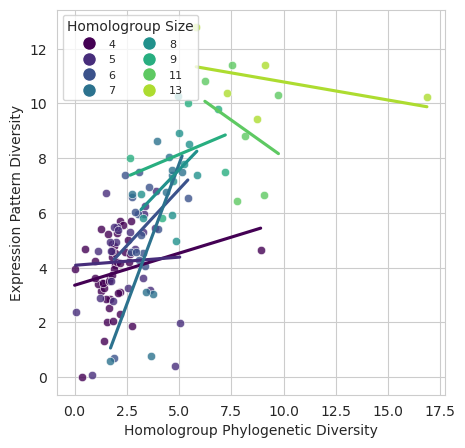

In [13]:
sns.set_style("whitegrid")
#define color palette
# Get the "Spectral" colormap
cmap = plt.cm.get_cmap('viridis')

# Divide the colormap into 14 bins
num_bins = 8
colors = [cmap(i / num_bins) for i in range(num_bins)]

# Extract hex codes
colors = [mcolors.to_hex(color) for color in colors]
#make palette
custom_palette = sns.color_palette(colors)
sns.set_palette(custom_palette)

#colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#ff9896', '#21130d', '#98df8a', '#ffbb78']
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))

slopes = {}
legend_labels = []
r2_values = []
p_values = {}
r_values = {}


col_idx = 0
for i in range(4,70):
    cluster_data = data[data['n.genes'] == i]
    if len(cluster_data) >= 5:
        sns.regplot(data=cluster_data, y="standardized.expression.pattern.diversity", x="gene.cluster.phylogenetic.diversity", ax=ax1, ci=None, color=colors[col_idx], marker="")
        sns.scatterplot(data=cluster_data, y="standardized.expression.pattern.diversity", x="gene.cluster.phylogenetic.diversity", ax=ax1, alpha=0.8)
        legend_labels.append(f'{i}')
        
        slope, intercept, r_value, p_value, std_err = linregress(cluster_data["gene.cluster.phylogenetic.diversity"], cluster_data["standardized.expression.pattern.diversity"])
        slopes[i] = slope
        p_values[i] = p_value
        r_values[i] = r_value
        
        r2_values.append(r_value**2)
        col_idx += 1

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=legend_labels[i]) for i in range(len(legend_labels))]
ax1.legend(handles=legend_elements, loc='upper left', title='Homologroup Size', ncol=2, fontsize=8)
ax1.set_xlabel('Homologroup Phylogenetic Diversity')
ax1.set_ylabel('Expression Pattern Diversity')

In [19]:
smaller = [4,5,6,7,8,9]
r_values_smaller = []
for size in r_values:
    if size in smaller:
        r_values_smaller.append(r_values[size])

mean_r = sum(r_values_smaller) / len(r_values_smaller)
print(f"Mean r = {mean_r}")
print(f"Range r = [{min(r_values_smaller), max(r_values_smaller)}]")

Mean r = 0.35209979877664654
Range r = [(0.0407968402989899, 0.6763453996852719)]


In [21]:
larger = [11,13]
r_values_larger = []
for size in r_values:
    if size in larger:
        r_values_larger.append(r_values[size])

mean_r = sum(r_values_larger) / len(r_values_larger)
print(f"Mean r = {mean_r}")
print(f"Range r = [{min(r_values_larger), max(r_values_larger)}]")

Mean r = -0.37555246734817305
Range r = [(-0.4380078416473234, -0.3130970930490227)]


In [6]:
print(r_values)

{4: 0.23759008456836847, 5: 0.0407968402989899, 6: 0.3758121270123099, 7: 0.6763453996852719, 8: 0.4310121329591287, 9: 0.35104220813581033, 11: -0.3130970930490227, 13: -0.4380078416473234}


In [47]:
slope_values = []
for size in slopes:
    slope_values.append(slopes[size])
    
mean_slope = sum(slope_values) / len(slope_values)
ci = calculate_95_ci(slope_values)
print(f"mean slope = {mean_slope}, 95%CI = {ci}")

mean slope = 0.45116054908639436, 95%CI = (-0.0952497905002867, 0.9975708886730754)


In [48]:
r_value_list = []
for size in r_values:
    r_value_list.append(r_values[size])
    
mean_slope = sum(r_value_list) / len(r_value_list)
ci = calculate_95_ci(r_value_list)
print(f"mean r = {mean_slope}, 95%CI = {ci}")

mean r = 0.17018673224544165, 95%CI = (-0.09484435162465357, 0.4352178161155369)


##### Null model analysis

In [5]:
#calculate r for each iteration
# load null model data
null_model_data_file = '/home/gabe/Desktop/mtstp/data/intermediate_data/gene_cluster_diversity_analysis/null_model_results_close.json'

with open(null_model_data_file, 'r') as infile:
    null_model_data = json.load(infile)

#initialize list to store values
global_null_r_values = []
#start with global
for i in range(len(null_model_data['global.null.r2.distribution'])):
    #get r2 value
    r2 = null_model_data['global.null.r2.distribution'][i]
    #get sign
    if null_model_data['global.null.slope.distribution'][i] > 0:
        slope_sign = 1
    elif null_model_data['global.null.slope.distribution'][i] < 0:
        slope_sign = -1
    else:
        print('Error')
        
    #get r
    r = math.sqrt(r2) * slope_sign
    global_null_r_values.append(r)
    
#add global null r values to null dictionary
null_model_data['global.null.r.distribution'] = global_null_r_values

#add entry for local null r distribution
null_model_data['local.null.r.distributions'] = {}
#now do the same for each family size
for group_size in null_model_data['local.slopes']:
    #initialize list to store values
    local_null_r_values = []
    for i in range(len(null_model_data['local.null.r2.distributions'][group_size])):
        #get r2 value
        r2 = null_model_data['local.null.r2.distributions'][group_size][i]
        #get sign
        if null_model_data['local.null.r2.distributions'][group_size][i] > 0:
            slope_sign = 1
        elif null_model_data['local.null.r2.distributions'][group_size][i] < 0:
            slope_sign = -1
        elif null_model_data['local.null.r2.distributions'][group_size][i] == 0:
            print('Slope is 0')
            
        #get r
        r = math.sqrt(r2) * slope_sign
        local_null_r_values.append(r)
        
    #add list to dictionary
    null_model_data['local.null.r.distributions'][group_size] = local_null_r_values
    
#now calculate observed r
#add entry for local r values
null_model_data['local.r'] = {}
#now do the same for each family size
for group_size in null_model_data['local.r2']:
    r2 = null_model_data['local.r2'][group_size]
    #get sign
    if null_model_data['local.slopes'][group_size] > 0:
        slope_sign = 1
    elif null_model_data['local.slopes'][group_size] < 0:
        slope_sign = -1
    elif null_model_data['local.slopes'][group_size] == 0:
        print('Slope is 0')
    
    #get r
    r = math.sqrt(r2) * slope_sign
    null_model_data['local.r'][group_size] = r
    
#calculate global r
r2 = null_model_data['global.r2']
global_r = math.sqrt(r2)
null_model_data['global.r'] = global_r

In [50]:
#initialize data frame
ses_data = pd.DataFrame(columns=['gene-family-size', 'slope-ses', 'r-ses', 'slope-p', 'r-p'])

#calculate global slope ses
global_slope_ses = calculate_standardized_effect(null_model_data['global.slope'], null_model_data['global.null.slope.distribution'])
global_r_ses = calculate_standardized_effect(null_model_data['global.r'], null_model_data['global.null.r.distribution'])
global_slope_p = calculate_prob_obs_greater_than_null(null_model_data['global.slope'], null_model_data['global.null.slope.distribution'])
global_r_p = calculate_prob_obs_greater_than_null(null_model_data['global.r'], null_model_data['global.null.r.distribution'])
#add to ses_data
global_data = pd.DataFrame({'gene-family-size' : 'Total', 
                            'slope-ses' : global_slope_ses, 
                            'r-ses' : global_r_ses,
                           'slope-p' : global_slope_p,
                           'r-p' : global_r_p},
                              index=[0])
ses_data = pd.concat([ses_data, global_data], ignore_index=True)


#Now to iterate through all of the gene family sizes
for gene_family_size in null_model_data['local.slopes']:
    
    #get observed slope and r2
    observed_slope = null_model_data['local.slopes'][gene_family_size]
    observed_r = null_model_data['local.r'][gene_family_size]
    
    #get null distributions
    null_slope_distribution = null_model_data['local.null.slope.distributions'][gene_family_size]
    null_r_distribution = null_model_data['local.null.r.distributions'][gene_family_size]
    
    #calculate slope-ses
    local_slope_ses = calculate_standardized_effect(observed_slope, null_slope_distribution)
    local_r_ses = calculate_standardized_effect(observed_r, null_r_distribution)
    local_slope_p = calculate_prob_obs_greater_than_null(observed_slope, null_slope_distribution)
    local_r_p = calculate_prob_obs_greater_than_null(observed_r, null_r_distribution)
    
    #add to ses_data
    local_data = pd.DataFrame({'gene-family-size' : gene_family_size, 
                            'slope-ses' : local_slope_ses, 
                            'r-ses' : local_r_ses,
                              'slope-p' : local_slope_p,
                              'r-p' : local_r_p},
                              index=[0])
    ses_data = pd.concat([ses_data, local_data], ignore_index=True)


#sort data into correct order
gene_family_sizes = ['Total', '4', '5', '6', '7', '8', '9','11', '13']
ses_data['gene-family-size'] = pd.Categorical(ses_data['gene-family-size'], categories = gene_family_sizes)
ses_data = ses_data.sort_values(by='gene-family-size')

ses_data

/tmp/ipykernel_99705/4097687976.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ses_data = pd.concat([ses_data, global_data], ignore_index=True)


,gene-family-size,slope-ses,r-ses,slope-p,r-p
0,Total,-4.075340,-3.099490,1.000,0.996
1,4,1.999710,1.222641,0.014,0.119
4,5,0.348024,-0.985186,0.351,0.835
5,6,2.444219,0.994810,0.009,0.166
6,7,6.110705,2.264798,0.000,0.028
7,8,1.990671,0.829745,0.025,0.210
8,9,1.152409,-0.279963,0.131,0.564
3,11,-1.298748,-2.833075,0.908,1.000
2,13,-0.893563,-3.314898,0.810,1.000


##### null global stats

In [51]:
#null global slope stats
average_null_slope = sum(null_model_data['global.null.slope.distribution']) / len(null_model_data['global.null.slope.distribution'])
ci = calculate_95_ci(null_model_data['global.null.slope.distribution'])
print(f"mean slope = {average_null_slope}, 95%CI = {ci}")

mean slope = 0.8828697896223637, 95%CI = (0.8816953661794076, 0.8840442130653199)


In [248]:
#null global r2 stats
average_null_r = sum(null_model_data['global.null.r.distribution']) / len(null_model_data['global.null.r.distribution'])
ci = calculate_95_ci(null_model_data['global.null.r.distribution'])
print(f"mean r = {average_null_r}, 95%CI = {ci}")

mean r = 0.9425138439014827, 95%CI = (0.9421713412557324, 0.942856346547233)


##### null local stats

In [249]:
ses_data_local_only = ses_data.drop(ses_data.index[0])
#calculate mean and 95% CI for local slopes ses
group_slopes_ses = list(ses_data_local_only['slope-ses'])
mean_group_slope_ses = sum(group_slopes_ses) / len(group_slopes_ses)
ci = calculate_95_ci(group_slopes_ses)
print(f"mean slope SES = {mean_group_slope_ses}, 95%CI = {ci}")

mean slope SES = 1.4816783413856698, 95%CI = (-0.12535420921806484, 3.0887108919894044)


In [250]:
#calculate mean and 95% CI for local slopes p
group_slopes_p = list(ses_data_local_only['slope-p'])
mean_group_slope_p = sum(group_slopes_p) / len(group_slopes_p)
ci = calculate_95_ci(group_slopes_p)
print(f"mean slope P = {mean_group_slope_p}, 95%CI = {ci}")

mean slope P = 0.281, 95%CI = (0.020383216583028663, 0.5416167834169714)


In [251]:
#calculate mean and 95% CI for local r2 ses
group_r_ses = list(ses_data_local_only['r-ses'])
mean_group_r_ses = sum(group_r_ses) / len(group_r_ses)
ci = calculate_95_ci(group_r_ses)
print(f"mean r SES = {mean_group_r_ses}, 95%CI = {ci}")

mean r SES = -0.26264107299829437, 95%CI = (-1.6439407703436808, 1.118658624347092)


In [252]:
#calculate mean and 95% CI for local r2 ses
group_r_p = list(ses_data_local_only['r-p'])
mean_group_r_p = sum(group_r2_p) / len(group_r_p)
ci = calculate_95_ci(group_r_p)
print(f"mean r P = {mean_group_r_p}, 95%CI = {ci}")

mean r P = 0.39349999999999996, 95%CI = (0.20584271077511307, 0.774657289224887)


##### Main visualization


Polynomial Regression (Order 2) Model Fit Summary:

Model Equation:
           2
-0.006066 x + 0.9771 x + 2.258
Sum of squared residuals: 750.6054758959806

Linear Model Fit Summary:

Fitted Parameters:
Slope (m) = 0.8056478881334027
Intercept (c) = 2.8104468217616994
Sum of squared residuals: 780.5546399739799


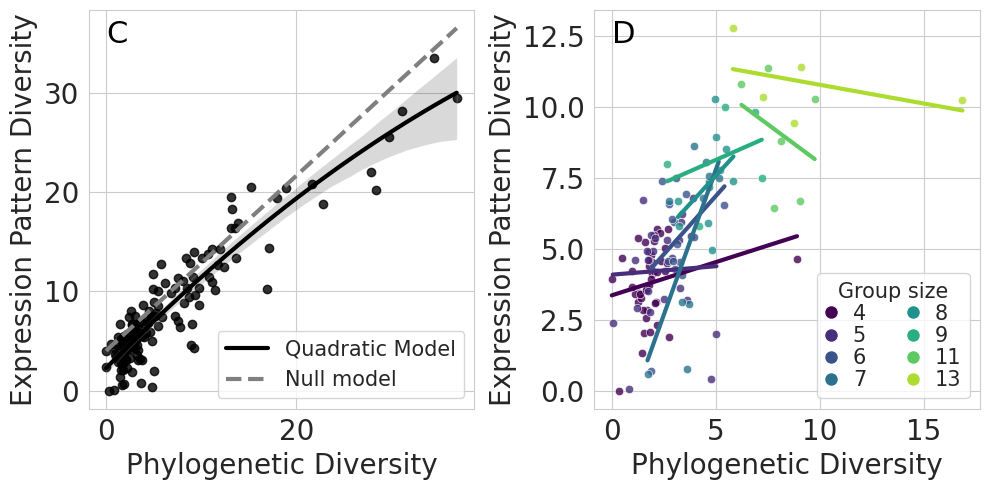

In [12]:
sns.set_style("whitegrid")
sns.set_palette('tab10')

#plot
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))

#A
sns.regplot(data=data, y="standardized.expression.pattern.diversity", x="gene.cluster.phylogenetic.diversity", 
            ax=ax1, order=2, line_kws={"linewidth": 3},
           color="black")

ax1.set_ylabel("Expression Pattern Diversity")
ax1.set_xlabel("Homologroup Phylogenetic Diversity")

#fit models
global_polynomial_model = fit_polynomial(data, y_col="standardized.expression.pattern.diversity", 
                                                     x_col="gene.cluster.phylogenetic.diversity")
global_linear_fit_model = fit_linear_model(data, y_col="standardized.expression.pattern.diversity", 
                                                     x_col="gene.cluster.phylogenetic.diversity")

#plot global null results
#define x values
start_x = min(list(data['gene.cluster.phylogenetic.diversity']))
stop_x = start = max(list(data['gene.cluster.phylogenetic.diversity']))
x = np.linspace(start_x, stop_x, 100)
#get average slope from simulation
m = float(sum(null_model_data['global.null.slope.distribution']) / len(null_model_data['global.null.slope.distribution']))
b = float(sum(null_model_data['global.null.intercept.distribution']) / len(null_model_data['global.null.intercept.distribution']))
#calculate predicted y
y = m * x + b
#plot
null_line = sns.lineplot(x=x, y=y, ax=ax1, alpha=1, color='tab:gray', linestyle="--", linewidth=3)
    
    
#define legend
legend_lines = [mlines.Line2D([0], [0], color='black', label='Quadratic Model', linewidth=3),
                mlines.Line2D([0], [0], color='tab:gray', label='Null model', linewidth=3, linestyle='--')]

ax1.legend(handles=legend_lines, loc='lower right', fontsize=15)

ax1.set_xlabel('Phylogenetic Diversity', fontsize=20)
ax1.set_ylabel('Expression Pattern Diversity', fontsize=20) 





#B
cmap = plt.cm.get_cmap('viridis')

# Divide the colormap into 14 bins
num_bins = 8
colors = [cmap(i / num_bins) for i in range(num_bins)]

# Extract hex codes
colors = [mcolors.to_hex(color) for color in colors]
#make palette
custom_palette = sns.color_palette(colors)
sns.set_palette(custom_palette)

slopes = {}
legend_labels = []
color_dict = {}

col_idx = 0
for i in range(4,70):
    cluster_data = data[data['n.genes'] == i]
    if len(cluster_data) >= 5:
        sns.regplot(data=cluster_data, y="standardized.expression.pattern.diversity", x="gene.cluster.phylogenetic.diversity", ax=ax2, ci=None, color=colors[col_idx], marker="", line_kws={"linewidth": 3})
        sns.scatterplot(data=cluster_data, y="standardized.expression.pattern.diversity", x="gene.cluster.phylogenetic.diversity", color=colors[col_idx], ax=ax2, alpha=0.8)
        legend_labels.append(f'{i}')
        

        slope, intercept, r_value, p_value, std_err = linregress(cluster_data["gene.cluster.phylogenetic.diversity"], cluster_data["standardized.expression.pattern.diversity"])
        slopes[i] = slope
        
        color_dict[i] = colors[col_idx]
        col_idx += 1

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=legend_labels[i]) for i in range(len(legend_labels))]
ax2.legend(handles=legend_elements, loc='lower right', title='Group size', title_fontsize = 15, ncol=2, fontsize=15, labelspacing = 0.1, handlelength=0.5)
ax2.set_xlabel('Phylogenetic Diversity', fontsize=20)
ax2.set_ylabel('Expression Pattern Diversity', fontsize=20)






#share axes
ax2.get_shared_y_axes().join(ax2, ax3)


ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax3.tick_params(axis='x', labelsize=20)


#add plot labels
ax1.text(0, 35, s='C', fontsize=22, color='black')
ax2.text(0, 12.25, s='D', fontsize=22, color='black')


plt.tight_layout()
plt.savefig('/home/gabe/Desktop/mtstp/figures/primary/expression_pattern_vs_phylogenetic_diversity_close.pdf')

#### Local null model plot

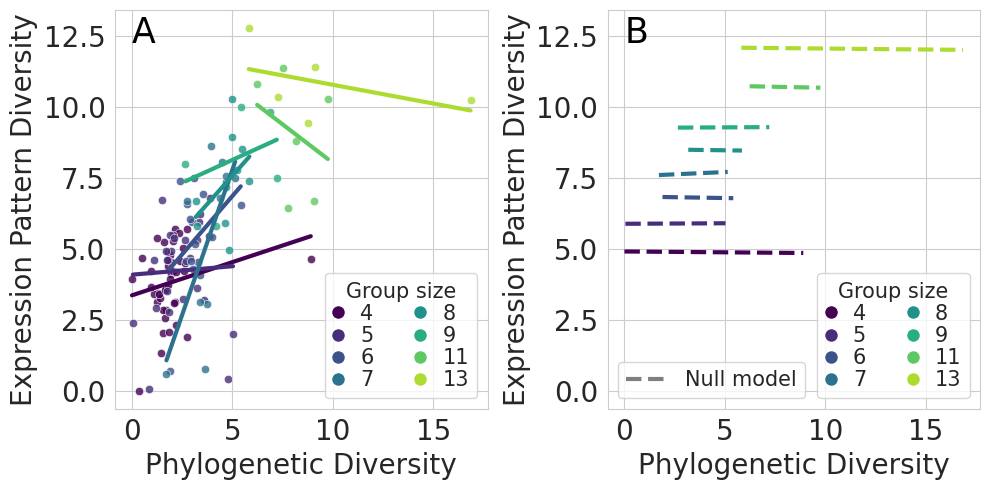

In [18]:
sns.set_style("whitegrid")
sns.set_palette('tab10')

#plot
fig, [ax2, ax3] = plt.subplots(1, 2, figsize=(10, 5))

#B
cmap = plt.cm.get_cmap('viridis')

# Divide the colormap into 14 bins
num_bins = 8
colors = [cmap(i / num_bins) for i in range(num_bins)]

# Extract hex codes
colors = [mcolors.to_hex(color) for color in colors]
#make palette
custom_palette = sns.color_palette(colors)
sns.set_palette(custom_palette)

slopes = {}
legend_labels = []
color_dict = {}

col_idx = 0
for i in range(4,70):
    cluster_data = data[data['n.genes'] == i]
    if len(cluster_data) >= 5:
        sns.regplot(data=cluster_data, y="standardized.expression.pattern.diversity", x="gene.cluster.phylogenetic.diversity", ax=ax2, ci=None, color=colors[col_idx], marker="", line_kws={"linewidth": 3})
        sns.scatterplot(data=cluster_data, y="standardized.expression.pattern.diversity", x="gene.cluster.phylogenetic.diversity", color=colors[col_idx], ax=ax2, alpha=0.8)
        legend_labels.append(f'{i}')
        

        slope, intercept, r_value, p_value, std_err = linregress(cluster_data["gene.cluster.phylogenetic.diversity"], cluster_data["standardized.expression.pattern.diversity"])
        slopes[i] = slope
        
        color_dict[i] = colors[col_idx]
        col_idx += 1

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=legend_labels[i]) for i in range(len(legend_labels))]
ax2.legend(handles=legend_elements, loc='lower right', title='Group size', title_fontsize = 15, ncol=2, fontsize=15, labelspacing = 0.1, handlelength=0.5)
ax2.set_xlabel('Phylogenetic Diversity', fontsize=20)
ax2.set_ylabel('Expression Pattern Diversity', fontsize=20)




#C
#local null model predictions

#plot null model results
col_idx = 0
for homologroup_size in null_model_data['local.null.slope.distributions']:
    #define x values
    start_x = min(list(data[data['n.genes'] == int(homologroup_size)]['gene.cluster.phylogenetic.diversity']))
    stop_x = start = max(list(data[data['n.genes'] == int(homologroup_size)]['gene.cluster.phylogenetic.diversity']))
    x = np.linspace(start_x, stop_x, 100)
    #get average slope from simulation
    m = float(sum(null_model_data['local.null.slope.distributions'][homologroup_size]) / len(null_model_data['local.null.slope.distributions'][homologroup_size]))
    b = float(sum(null_model_data['local.null.intercept.distributions'][homologroup_size]) / len(null_model_data['local.null.intercept.distributions'][homologroup_size]))
    #calculate predicted y
    y = m * x + b
    #plot
    null_line = sns.lineplot(x=x, y=y, ax=ax3, alpha=1, color=color_dict[int(homologroup_size)], linestyle="--", linewidth=3)
    col_idx += 1
    
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=legend_labels[i]) for i in range(len(legend_labels))]
legend1 = ax3.legend(handles=legend_elements, loc='lower right', title='Group size', title_fontsize = 15, ncol=2, fontsize=15, labelspacing = 0.1, handlelength=0.5)
ax3.set_xlabel('Phylogenetic Diversity', fontsize=20)
ax3.set_ylabel('Expression Pattern Diversity', fontsize=20)

#add legend
ax3.add_artist(legend1)
#add second legend
#define legend
legend2_lines = [mlines.Line2D([0], [0], color='tab:gray', label='Null model', linewidth=3, linestyle='--')]

ax3.legend(handles=legend2_lines, loc='lower left', fontsize=15)

#share axes
ax2.get_shared_y_axes().join(ax2, ax3)

ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax3.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)

#add plot labels
ax2.text(0, 12.25, s='A', fontsize=25, color='black')
ax3.text(0, 12.25, s='B', fontsize=25, color='black')

plt.tight_layout()
plt.savefig('/home/gabe/Desktop/mtstp/figures/supplement/expression_pattern_vs_phylogenetic_diversity_close_null_comp.pdf')

### PSI-BLAST 5 (E-value cutoff = e-5, %identity cutoff = 20%, query coverage cutoff = 0.7)

Generation of this data was described previously.The only difference is the null model was implemented by:

    null_gene_family_diversity_model_global_distant.R


#### Visualization of homologous group sizes

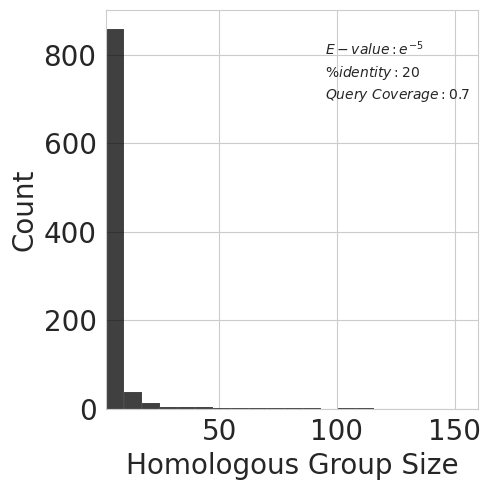

In [89]:
#read homologous groupings
with open('/home/gabe/Desktop/mtstp/data/intermediate_data/gene_cluster_diversity_analysis/psiblast_id-20_e-neg-5_cov-0.7_sequence_clusters.json') as infile:
    data = json.load(infile)
    
#make list of homologous group sizes
group_sizes = []
for group in data:
    group_sizes.append(len(data[group]))
    
#plot histogram
sns.set_style('whitegrid')
sns.set_palette('tab10')
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
sns.histplot(group_sizes, bins=500, kde=False, ax=ax1, color="black")
ax1.set_xlabel('Homologous Group Size', fontsize=20)
ax1.set_ylabel('Count', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.text(95, 800, r"$E-value: e^{-5}$", fontsize=10)
ax1.text(95, 750, r"$\%identity: 20$", fontsize=10)
ax1.text(95, 700, r"$Query\ Coverage: 0.7$", fontsize=10)
ax1.set_xlim([2, 160])
plt.tight_layout()
plt.savefig('/home/gabe/Desktop/mtstp/figures/supplement/homologous_group_sizes_histogram_distant.pdf')

In [192]:
#show counts of the numbers of groups that will be used in groups size-specific analysis
element_count = Counter(group_sizes)
available_groups = 0
# Print the counts
for element, count in element_count.items():
    if count >= 5 and element > 3:
        print(f"Group Size {element} occurs {count} times")
        available_groups += count
print(f"{available_groups} total groups")

Group Size 5 occurs 39 times
Group Size 4 occurs 90 times
Group Size 7 occurs 25 times
Group Size 14 occurs 5 times
Group Size 16 occurs 5 times
Group Size 9 occurs 10 times
Group Size 8 occurs 10 times
Group Size 10 occurs 10 times
Group Size 6 occurs 31 times
Group Size 12 occurs 5 times
230 total groups


#### Global correlations

In [90]:
#laod data
data = pd.read_csv("/home/gabe/Desktop/mtstp/data/intermediate_data/gene_cluster_diversity_analysis/gene_family_diversity_vs_expression_diversity_global_data_distant.csv")
#drop rows with NA (indicated a Tree could not be computed for said gene cluster)
data = data.dropna()

In [91]:
data

,cluster,expression.pattern.diversity,centered.expression.pattern.diversity,standardized.expression.pattern.diversity,p.random,mean.tau,upper_tau_ci,lower_tau_ci,gene.cluster.phylogenetic.diversity,n.genes
1,group_1,1177.209248,1077.348995,29.775757,1.0,0.714199,0.762797,0.665600,37.594739,50.0
2,group_2,750.037179,578.494755,24.723427,1.0,0.684291,0.761182,0.607400,24.780394,36.0
3,group_3,241.867669,218.771024,5.771395,1.0,0.912716,1.055862,0.769570,3.891267,5.0
5,group_5,724.890854,472.338610,35.076300,1.0,0.583971,0.636633,0.531309,58.679838,60.0
10,group_10,428.591115,315.825372,17.355616,1.0,0.621014,0.735200,0.506828,13.969869,23.0
...,...,...,...,...,...,...,...,...,...,...
831,group_1268,3228.361390,1564.212264,3.946589,1.0,0.691223,1.385855,-0.003410,0.004462,4.0
852,group_1295,133.413955,114.085884,3.590697,1.0,0.898244,0.974811,0.821677,1.151052,4.0
857,group_1301,7.155872,3.750008,5.115644,1.0,0.601711,1.037610,0.165812,1.366246,4.0
864,group_1310,36.877276,30.701495,0.177158,1.0,0.945216,0.963990,0.926443,1.408296,4.0


##### Phylogenetic diversity vs group size

Text(0.5, 0, 'Group Size')

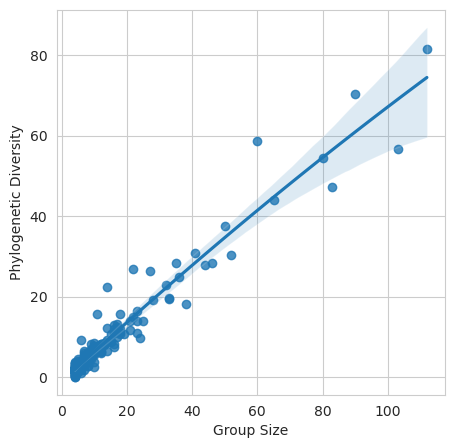

In [92]:
sns.set_style("whitegrid")
sns.set_palette('tab10')
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))

sns.regplot(data=data, y="gene.cluster.phylogenetic.diversity", x="n.genes", ax=ax1, order=2)

ax1.set_ylabel("Phylogenetic Diversity")
ax1.set_xlabel("Group Size")

##### Expression Pattern Diversity vs Group Phylogenetic Diversity and Size

Text(0.5, 0, 'Homologous Group Size')

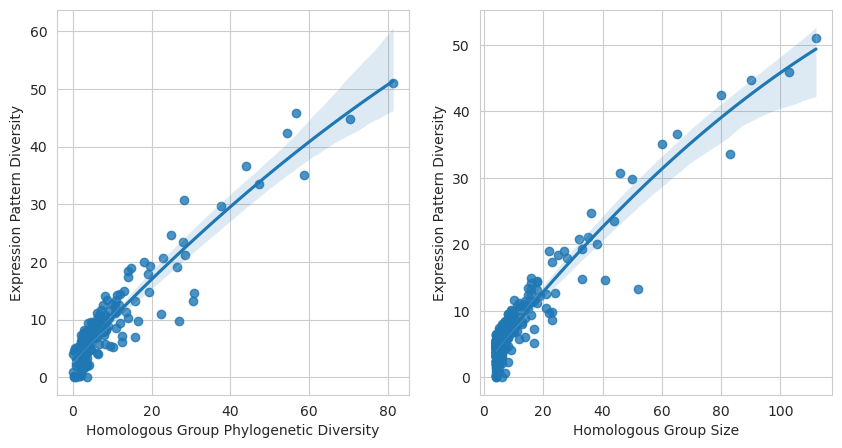

In [265]:
sns.set_style("whitegrid")
sns.set_palette('tab10')
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(10, 5))

sns.regplot(data=data, y="standardized.expression.pattern.diversity", x="gene.cluster.phylogenetic.diversity", ax=ax1, order=2)
sns.regplot(data=data, y="standardized.expression.pattern.diversity", x="n.genes", ax=ax2, order=2)

ax1.set_ylabel("Expression Pattern Diversity")
ax1.set_xlabel("Homologous Group Phylogenetic Diversity")

ax2.set_ylabel("Expression Pattern Diversity")
ax2.set_xlabel("Homologous Group Size")

##### Second order polynomial model fit for expression pattern diversity vs Phylogenetic diversity


Polynomial Regression (Order 2) Model Fit Summary:

Model Equation:
           2
-0.001659 x + 0.7289 x + 3.071
Sum of squared residuals: 1668.83836646571

Linear Model Fit Summary:

Fitted Parameters:
Slope (m) = 0.6364394313989108
Intercept (c) = 3.4357679393763423
Sum of squared residuals: 1713.9876895890925


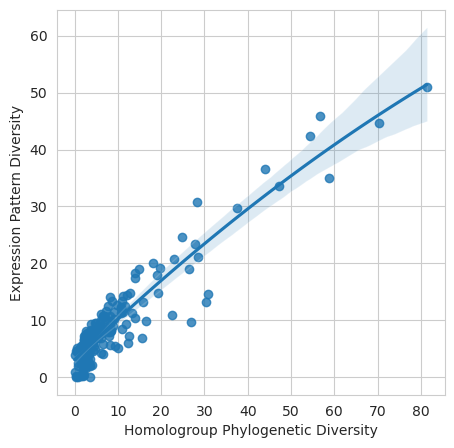

In [266]:
sns.set_style("whitegrid")
sns.set_palette('tab10')
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))

sns.regplot(data=data, y="standardized.expression.pattern.diversity", x="gene.cluster.phylogenetic.diversity", ax=ax1, order=2)

ax1.set_ylabel("Expression Pattern Diversity")
ax1.set_xlabel("Homologroup Phylogenetic Diversity")

#fit models
global_polynomial_model = fit_polynomial(data, y_col="standardized.expression.pattern.diversity", 
                                                     x_col="gene.cluster.phylogenetic.diversity")
global_linear_fit_model = fit_linear_model(data, y_col="standardized.expression.pattern.diversity", 
                                                     x_col="gene.cluster.phylogenetic.diversity")

##### Linear models by homologous group size

Text(0, 0.5, 'Expression Pattern Diversity')

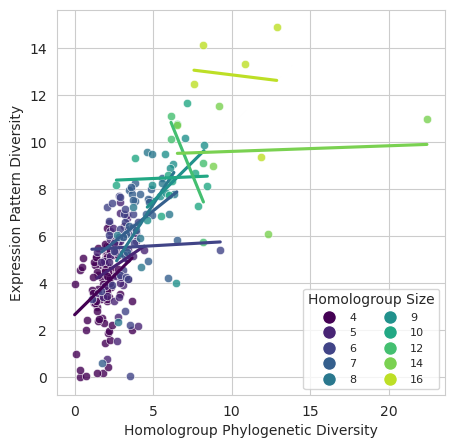

In [203]:
sns.set_style("whitegrid")
#define color palette
# Get the "Spectral" colormap
cmap = plt.cm.get_cmap('viridis')

# Divide the colormap into 14 bins
num_bins = 10
colors = [cmap(i / num_bins) for i in range(num_bins)]

# Extract hex codes
colors = [mcolors.to_hex(color) for color in colors]
#make palette
custom_palette = sns.color_palette(colors)
sns.set_palette(custom_palette)

#colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#ff9896', '#21130d', '#98df8a', '#ffbb78']
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))

slopes = {}
legend_labels = []
r2_values = []
p_values = {}
r_values = {}


col_idx = 0
for i in range(4,70):
    cluster_data = data[data['n.genes'] == i]
    if len(cluster_data) >= 5:
        sns.regplot(data=cluster_data, y="standardized.expression.pattern.diversity", x="gene.cluster.phylogenetic.diversity", ax=ax1, ci=None, color=colors[col_idx], marker="")
        sns.scatterplot(data=cluster_data, y="standardized.expression.pattern.diversity", x="gene.cluster.phylogenetic.diversity", ax=ax1, alpha=0.8)
        legend_labels.append(f'{i}')
        
        slope, intercept, r_value, p_value, std_err = linregress(cluster_data["gene.cluster.phylogenetic.diversity"], cluster_data["standardized.expression.pattern.diversity"])
        slopes[i] = slope
        p_values[i] = p_value
        r_values[i] = r_value
        
        r2_values.append(r_value**2)
        col_idx += 1

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=legend_labels[i]) for i in range(len(legend_labels))]
ax1.legend(handles=legend_elements, loc='lower right', title='Homologroup Size', ncol=2, fontsize=8)
ax1.set_xlabel('Homologroup Phylogenetic Diversity')
ax1.set_ylabel('Expression Pattern Diversity')

In [204]:
slope_values = []
for size in slopes:
    slope_values.append(slopes[size])
    
mean_slope = sum(slope_values) / len(slope_values)
ci = calculate_95_ci(slope_values)
print(f"mean slope = {mean_slope}, 95%CI = {ci}")

mean slope = 0.17101233172151495, 95%CI = (-0.2830380187000351, 0.6250626821430649)


In [267]:
r_value_list = []
for size in r_values:
    r_value_list.append(r_values[size])
    
mean_slope = sum(r_value_list) / len(r_value_list)
ci = calculate_95_ci(r_value_list)
print(f"mean r = {mean_slope}, 95%CI = {ci}")

mean r = 0.17018673224544165, 95%CI = (-0.09484435162465357, 0.4352178161155369)


##### Null model analysis

In [93]:
#calculate r for each iteration
# load null model data
null_model_data_file = '/home/gabe/Desktop/mtstp/data/intermediate_data/gene_cluster_diversity_analysis/null_model_results_distant.json'

with open(null_model_data_file, 'r') as infile:
    null_model_data = json.load(infile)

#initialize list to store values
global_null_r_values = []
#start with global
for i in range(len(null_model_data['global.null.r2.distribution'])):
    #get r2 value
    r2 = null_model_data['global.null.r2.distribution'][i]
    #get sign
    if null_model_data['global.null.slope.distribution'][i] > 0:
        slope_sign = 1
    elif null_model_data['global.null.slope.distribution'][i] < 0:
        slope_sign = -1
    else:
        print('Error')
        
    #get r
    r = math.sqrt(r2) * slope_sign
    global_null_r_values.append(r)
    
#add global null r values to null dictionary
null_model_data['global.null.r.distribution'] = global_null_r_values

#add entry for local null r distribution
null_model_data['local.null.r.distributions'] = {}
#now do the same for each family size
for group_size in null_model_data['local.slopes']:
    #initialize list to store values
    local_null_r_values = []
    for i in range(len(null_model_data['local.null.r2.distributions'][group_size])):
        #get r2 value
        r2 = null_model_data['local.null.r2.distributions'][group_size][i]
        #get sign
        if null_model_data['local.null.r2.distributions'][group_size][i] > 0:
            slope_sign = 1
        elif null_model_data['local.null.r2.distributions'][group_size][i] < 0:
            slope_sign = -1
        elif null_model_data['local.null.r2.distributions'][group_size][i] == 0:
            print('Slope is 0')
            
        #get r
        r = math.sqrt(r2) * slope_sign
        local_null_r_values.append(r)
        
    #add list to dictionary
    null_model_data['local.null.r.distributions'][group_size] = local_null_r_values
    
#now calculate observed r
#add entry for local r values
null_model_data['local.r'] = {}
#now do the same for each family size
for group_size in null_model_data['local.r2']:
    r2 = null_model_data['local.r2'][group_size]
    #get sign
    if null_model_data['local.slopes'][group_size] > 0:
        slope_sign = 1
    elif null_model_data['local.slopes'][group_size] < 0:
        slope_sign = -1
    elif null_model_data['local.slopes'][group_size] == 0:
        print('Slope is 0')
    
    #get r
    r = math.sqrt(r2) * slope_sign
    null_model_data['local.r'][group_size] = r
    
#calculate global r
r2 = null_model_data['global.r2']
global_r = math.sqrt(r2)
null_model_data['global.r'] = global_r

In [94]:
#initialize data frame
ses_data = pd.DataFrame(columns=['gene-family-size', 'slope-ses', 'r-ses', 'slope-p', 'r-p'])

#calculate global slope ses
global_slope_ses = calculate_standardized_effect(null_model_data['global.slope'], null_model_data['global.null.slope.distribution'])
global_r_ses = calculate_standardized_effect(null_model_data['global.r'], null_model_data['global.null.r.distribution'])
global_slope_p = calculate_prob_obs_greater_than_null(null_model_data['global.slope'], null_model_data['global.null.slope.distribution'])
global_r_p = calculate_prob_obs_greater_than_null(null_model_data['global.r'], null_model_data['global.null.r.distribution'])
#add to ses_data
global_data = pd.DataFrame({'gene-family-size' : 'Total', 
                            'slope-ses' : global_slope_ses, 
                            'r-ses' : global_r_ses,
                           'slope-p' : global_slope_p,
                           'r-p' : global_r_p},
                              index=[0])
ses_data = pd.concat([ses_data, global_data], ignore_index=True)


#Now to iterate through all of the gene family sizes
for gene_family_size in null_model_data['local.slopes']:
    
    #get observed slope and r2
    observed_slope = null_model_data['local.slopes'][gene_family_size]
    observed_r = null_model_data['local.r'][gene_family_size]
    
    #get null distributions
    null_slope_distribution = null_model_data['local.null.slope.distributions'][gene_family_size]
    null_r_distribution = null_model_data['local.null.r.distributions'][gene_family_size]
    
    #calculate slope-ses
    local_slope_ses = calculate_standardized_effect(observed_slope, null_slope_distribution)
    local_r_ses = calculate_standardized_effect(observed_r, null_r_distribution)
    local_slope_p = calculate_prob_obs_greater_than_null(observed_slope, null_slope_distribution)
    local_r_p = calculate_prob_obs_greater_than_null(observed_r, null_r_distribution)
    
    #add to ses_data
    local_data = pd.DataFrame({'gene-family-size' : gene_family_size, 
                            'slope-ses' : local_slope_ses, 
                            'r-ses' : local_r_ses,
                              'slope-p' : local_slope_p,
                              'r-p' : local_r_p},
                              index=[0])
    ses_data = pd.concat([ses_data, local_data], ignore_index=True)


#sort data into correct order
gene_family_sizes = ['Total', '4', '5', '6', '7', '8', '9','10', '12', '14', '16']
ses_data['gene-family-size'] = pd.Categorical(ses_data['gene-family-size'], categories = gene_family_sizes)
ses_data = ses_data.sort_values(by='gene-family-size')

ses_data

/tmp/ipykernel_99705/3127362590.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ses_data = pd.concat([ses_data, global_data], ignore_index=True)


,gene-family-size,slope-ses,r-ses,slope-p,r-p
0,Total,-5.472289,-3.889523,1.000,1.000
2,4,4.794734,3.689230,0.000,0.001
1,5,2.217783,0.870438,0.018,0.174
9,6,0.262302,-1.105491,0.418,0.880
3,7,2.597285,1.299489,0.005,0.119
7,8,3.667600,1.642773,0.000,0.078
6,9,1.892611,0.498839,0.026,0.301
8,10,0.149418,-1.232810,0.440,0.922
10,12,-2.954615,-4.676096,0.999,1.000
4,14,0.231405,-1.396814,0.413,0.921


##### null global stats

In [270]:
#null global slope stats
average_null_slope = sum(null_model_data['global.null.slope.distribution']) / len(null_model_data['global.null.slope.distribution'])
ci = calculate_95_ci(null_model_data['global.null.slope.distribution'])
print(f"mean slope = {average_null_slope}, 95%CI = {ci}")

mean slope = 0.7011187245306594, 95%CI = (0.7003861625847247, 0.701851286476594)


In [271]:
#null global r2 stats
average_null_r = sum(null_model_data['global.null.r.distribution']) / len(null_model_data['global.null.r.distribution'])
ci = calculate_95_ci(null_model_data['global.null.r.distribution'])
print(f"mean r = {average_null_r}, 95%CI = {ci}")

mean r = 0.9523933836624814, 95%CI = (0.9521429093476297, 0.9526438579773331)


##### null local stata

In [272]:
ses_data_local_only = ses_data.drop(ses_data.index[0])
#calculate mean and 95% CI for local slopes ses
group_slopes_ses = list(ses_data_local_only['slope-ses'])
mean_group_slope_ses = sum(group_slopes_ses) / len(group_slopes_ses)
ci = calculate_95_ci(group_slopes_ses)
print(f"mean slope SES = {mean_group_slope_ses}, 95%CI = {ci}")

mean slope SES = 1.2524031363137542, 95%CI = (-0.1333214773250695, 2.638127749952578)


In [274]:
#calculate mean and 95% CI for local slopes p
group_slopes_p = list(ses_data_local_only['slope-p'])
mean_group_slope_p = sum(group_slopes_p) / len(group_slopes_p)
ci = calculate_95_ci(group_slopes_p)
print(f"mean slope P = {mean_group_slope_p}, 95%CI = {ci}")

mean slope P = 0.2948, 95%CI = (0.08164400695324978, 0.5079559930467502)


In [213]:
#calculate mean and 95% CI for local r2 ses
group_r_ses = list(ses_data_local_only['r-ses'])
mean_group_r_ses = sum(group_r_ses) / len(group_r_ses)
ci = calculate_95_ci(group_r_ses)
print(f"mean r SES = {mean_group_r_ses}, 95%CI = {ci}")

mean r SES = -0.233527059343512, 95%CI = (-1.6756189622762927, 1.2085648435892689)


In [214]:
#calculate mean and 95% CI for local r2 ses
group_r_p = list(ses_data_local_only['r-p'])
mean_group_r_p = sum(group_r2_p) / len(group_r_p)
ci = calculate_95_ci(group_r_p)
print(f"mean r P = {mean_group_r_p}, 95%CI = {ci}")

mean r P = 0.31479999999999997, 95%CI = (0.2700571332469821, 0.8091428667530178)


##### Primaly figure and null model visualization


Polynomial Regression (Order 2) Model Fit Summary:

Model Equation:
           2
-0.001659 x + 0.7289 x + 3.071
Sum of squared residuals: 1668.83836646571

Linear Model Fit Summary:

Fitted Parameters:
Slope (m) = 0.6364394313989108
Intercept (c) = 3.4357679393763423
Sum of squared residuals: 1713.9876895890925


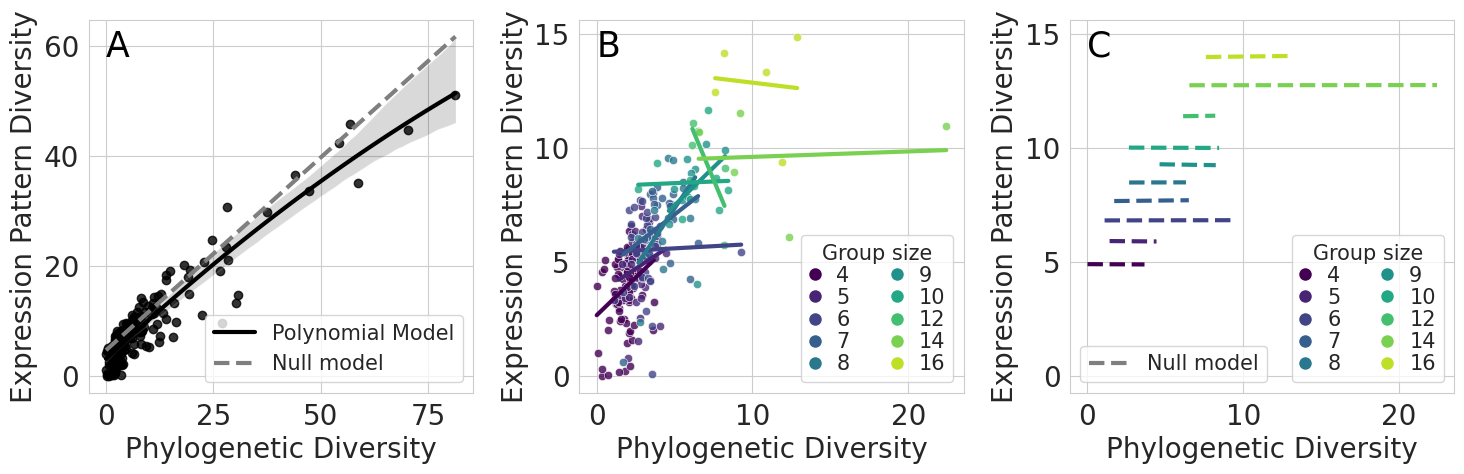

In [108]:
sns.set_style("whitegrid")
sns.set_palette('tab10')

#plot
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 5))

#A
sns.regplot(data=data, y="standardized.expression.pattern.diversity", x="gene.cluster.phylogenetic.diversity", 
            ax=ax1, order=2, line_kws={"linewidth": 3}, color="black")

ax1.set_ylabel("Expression Pattern Diversity")
ax1.set_xlabel("Homologroup Phylogenetic Diversity")

#fit models
global_polynomial_model = fit_polynomial(data, y_col="standardized.expression.pattern.diversity", 
                                                     x_col="gene.cluster.phylogenetic.diversity")
global_linear_fit_model = fit_linear_model(data, y_col="standardized.expression.pattern.diversity", 
                                                     x_col="gene.cluster.phylogenetic.diversity")

#plot global null results
#define x values
start_x = min(list(data['gene.cluster.phylogenetic.diversity']))
stop_x = start = max(list(data['gene.cluster.phylogenetic.diversity']))
x = np.linspace(start_x, stop_x, 100)
#get average slope from simulation
m = float(sum(null_model_data['global.null.slope.distribution']) / len(null_model_data['global.null.slope.distribution']))
b = float(sum(null_model_data['global.null.intercept.distribution']) / len(null_model_data['global.null.intercept.distribution']))
#calculate predicted y
y = m * x + b
#plot
null_line = sns.lineplot(x=x, y=y, ax=ax1, alpha=1, color='tab:gray', linestyle="--", linewidth=3)
    
    
#define legend
legend_lines = [mlines.Line2D([0], [0], color='black', label='Polynomial Model', linewidth=3),
                mlines.Line2D([0], [0], color='tab:gray', label='Null model', linewidth=3, linestyle='--')]

ax1.legend(handles=legend_lines, loc='lower right', fontsize=15)

ax1.set_xlabel('Phylogenetic Diversity', fontsize=20)
ax1.set_ylabel('Expression Pattern Diversity', fontsize=20) 



#B
cmap = plt.cm.get_cmap('viridis')

# Divide the colormap into 14 bins
num_bins = 10
colors = [cmap(i / num_bins) for i in range(num_bins)]

# Extract hex codes
colors = [mcolors.to_hex(color) for color in colors]
#make palette
custom_palette = sns.color_palette(colors)
sns.set_palette(custom_palette)

slopes = {}
legend_labels = []
color_dict = {}

col_idx = 0
for i in range(4,70):
    cluster_data = data[data['n.genes'] == i]
    if len(cluster_data) >= 5:
        sns.regplot(data=cluster_data, y="standardized.expression.pattern.diversity", x="gene.cluster.phylogenetic.diversity", ax=ax2, ci=None, color=colors[col_idx], marker="", line_kws={"linewidth": 3})
        sns.scatterplot(data=cluster_data, y="standardized.expression.pattern.diversity", x="gene.cluster.phylogenetic.diversity", color=colors[col_idx], ax=ax2, alpha=0.8)
        legend_labels.append(f'{i}')
        

        slope, intercept, r_value, p_value, std_err = linregress(cluster_data["gene.cluster.phylogenetic.diversity"], cluster_data["standardized.expression.pattern.diversity"])
        slopes[i] = slope
        
        color_dict[i] = colors[col_idx]
        col_idx += 1

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=legend_labels[i]) for i in range(len(legend_labels))]
ax2.legend(handles=legend_elements, loc='lower right', title='Group size', title_fontsize = 15, ncol=2, fontsize=15, labelspacing = 0.1, handlelength=0.5)
ax2.set_xlabel('Phylogenetic Diversity', fontsize=20)
ax2.set_ylabel('Expression Pattern Diversity', fontsize=20)


#C
#local null model predictions

#plot null model results
col_idx = 0
for homologroup_size in null_model_data['local.null.slope.distributions']:
    #define x values
    start_x = min(list(data[data['n.genes'] == int(homologroup_size)]['gene.cluster.phylogenetic.diversity']))
    stop_x = start = max(list(data[data['n.genes'] == int(homologroup_size)]['gene.cluster.phylogenetic.diversity']))
    x = np.linspace(start_x, stop_x, 100)
    #get average slope from simulation
    m = float(sum(null_model_data['local.null.slope.distributions'][homologroup_size]) / len(null_model_data['local.null.slope.distributions'][homologroup_size]))
    b = float(sum(null_model_data['local.null.intercept.distributions'][homologroup_size]) / len(null_model_data['local.null.intercept.distributions'][homologroup_size]))
    #calculate predicted y
    y = m * x + b
    #plot
    null_line = sns.lineplot(x=x, y=y, ax=ax3, alpha=1, color=color_dict[int(homologroup_size)], linestyle="--", linewidth=3)
    col_idx += 1
    
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=legend_labels[i]) for i in range(len(legend_labels))]
legend1 = ax3.legend(handles=legend_elements, loc='lower right', title='Group size', title_fontsize = 15, ncol=2, fontsize=15, labelspacing = 0.1, handlelength=0.5)
ax3.set_xlabel('Phylogenetic Diversity', fontsize=20)
ax3.set_ylabel('Expression Pattern Diversity', fontsize=20)

#add legend
ax3.add_artist(legend1)
#add second legend
#define legend
legend2_lines = [mlines.Line2D([0], [0], color='tab:gray', label='Null model', linewidth=3, linestyle='--')]

ax3.legend(handles=legend2_lines, loc='lower left', fontsize=15)

#share axes
ax2.get_shared_y_axes().join(ax2, ax3)


ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax3.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)

#add plot labels
ax1.text(0, 58, s='A', fontsize=25, color='black')
ax2.text(0, 14, s='B', fontsize=25, color='black')
ax3.text(0, 14, s='C', fontsize=25, color='black')

plt.tight_layout(pad=2)
plt.savefig('/home/gabe/Desktop/mtstp/figures/primary/expression_pattern_vs_phylogenetic_diversity_distant.pdf')